In [ ]:
pip install preprocessing

     |████████████████████████████████| 349 kB 19.6 MB/s 
     |████████████████████████████████| 1.4 MB 63.8 MB/s 
     |████████████████████████████████| 1.2 MB 66.3 MB/s 
  Created wheel for nltk: filename=nltk-3.2.4-py3-none-any.whl size=1367721 sha256=ff84a541092ec93c772174fcd87539dd2c9c1e41a7d6af22b80b5f3b0c7bf335
  Stored in directory: /root/.cache/pip/wheels/90/5e/9e/4cb46185f2a16c60e6fc524372ba7fef89ce3347734c8798b6
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
from preprocessing import *
base = Path('/content/drive/MyDrive/Project')
sys.path.append(str(base))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 38)]        0         
                                                                 
 lstm (LSTM)                 (None, 256)               302080    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 38)                9766      
                                                                 
Total params: 311,846
Trainable params: 311,846
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
3794/3794 [==============================] - 39s 9ms/step - loss: 0.7301 - accuracy: 0.7820 - val_loss: 0.6456 - val_accuracy: 0.7912
Epoch 2/50
3794/3794 [==============================] - 37s 10ms/step - loss: 0.6118 - accuracy: 0.8015 - val_loss: 0.6219 - val_accuracy: 0.7985
Epoch 3/50
3794/3794 [==============================] - 33s 9ms/step - loss: 0.5820 - accuracy: 0.8110 - val_loss: 0.5957 - val_accuracy: 0.8082
Epoch 4/50
3794/3794 [==============================] - 33s 9ms/step - loss: 0.5485 - accuracy: 0.8228 - val_loss: 0.5721 - val_accuracy: 0.8167
Epoch 5/50
3794/3794 [==============================] - 37s 10ms/step - loss: 0.5251 - accuracy: 0.8303 - val_loss: 0.5549 - val_accuracy: 0.8212
Epoch 6/50
3794/3794 [==============================] - 33s 9ms/step - loss: 0.5090 - accuracy: 0.8353 - val_loss: 0.5456 - val_accuracy: 0.8251
Epoch 7/50
3794/3794 [==============================] - 37s 10ms/step - loss: 0.4879 - accuracy: 0.8411 - val_loss: 0.5422 - val

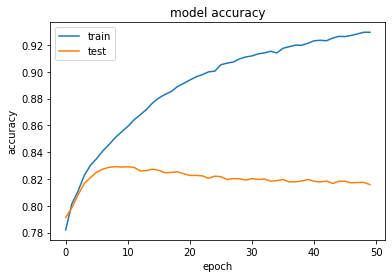

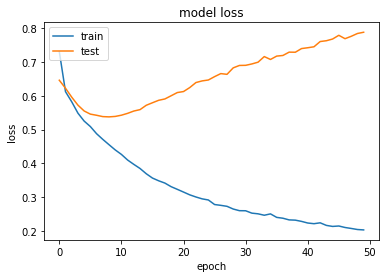

In [ ]:
import json
import tensorflow.keras as keras
from keras.applications.densenet import layers
import numpy as np
import matplotlib.pyplot as plt

mapping_path="/content/drive/MyDrive/Project/mapping.json"
sequence_length=64
single_file_dataset = "/content/drive/MyDrive/Project/file_dataset" 
LOSS = "sparse_categorical_crossentropy"    # error function for training
LEARNING_RATE = 0.001
EPOCHS = 50 # three seperate values # 2 10 20
NUM_UNITS = [256]   #number of units of neuron in internal layer of network this is one layer with 256 neurons # three seperate values # 64 128
BATCH_SIZE = 64     # amount of samples it will see before running back propogation  # 16 32 
save_model_path = "model4.h5"   # .h5 for saving keras model


def convert_songs_to_int(songs):
    # covert song in symbolic representaition to integer into sequences so that we can train our LSTM model
    # takes input as songs which is string of integer
    int_songs = []
    # store all dataset and mapping
    # load the mappings
    with open(mapping_path, "r") as fp:
        mappings = json.load(fp)
        # dictionary which contain all our symbols

    # cast songs string to list
    songs = songs.split()
    # splits a string at empty spaces and create items in list

    # map song to int
    for symbol in songs:
        int_songs.append(mappings[symbol])
    #print(int_songs)
    return int_songs

def load(file_path):
    with open(file_path, "r") as fp:
        song = fp.read()
    return song

def generating_training_sequences(sequence_length):
    # load the songs and map to int
    songs = load(single_file_dataset)
    #print(songs)
    int_songs = convert_songs_to_int(songs)
    # genearte the training sequence
    num_sequences=len(int_songs)-sequence_length
    input=[]
    target=[]
    for i in range(num_sequences):
        input.append(int_songs[i:i+sequence_length])
        target.append(int_songs[i+sequence_length])
    # one-hot encode the sequences
    # inputs: (# of sequences ,sequence length,vocabulary length)
    # easiest way to work with categorical data for neural network
    vocabulary_size=len(set(int_songs))
    inputs = keras.utils.to_categorical(input, num_classes=vocabulary_size)
    # input will now be a 3D array
    targets=np.array(target)
    return inputs,targets


def output_units_(mapping_path):
    with open(mapping_path, "r") as fp:
        mappings = json.load(fp)
    return len(mappings.keys())


def build_model(output_units, num_units, loss, learning_rate):
    # create model architecture
    input = keras.layers.Input(shape=(None, output_units))
    # shape is of the data which we will input in our model
    # None enables us to have as many timestamps as we want ,we than can generate however melodies we want
    # output_units tells us how many elements we have for each timestamp i.e our vocabulary size
    x = keras.layers.LSTM(num_units[0])(input)
    # add another node to graph

    x = keras.layers.Dropout(0.2)(x)
    # to avoid overfitting we use dropout layer
    # here the rate refers to amount of input data to be dropped
    output = keras.layers.Dense(output_units, activation="softmax")(x)

    model = keras.Model(input, output)

    # compile model

    model.compile(loss=loss, optimizer=keras.optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
    model.summary()
    # print some information about all the model
    return model


def train(output_units=output_units_(mapping_path), num_units=NUM_UNITS, loss=LOSS, learning_rate=LEARNING_RATE):
    # it will do all the functions that will train our dataset
    # generate training sequences
    # it is already created in preprocess.py

    input, target = generating_training_sequences(sequence_length)
    # build the network

    model = build_model(output_units, num_units, loss, learning_rate)
    # output units i.e how many neurons are there in output layer
    history=model.fit(input, target,validation_split=0.33, epochs=EPOCHS, batch_size=BATCH_SIZE)
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # save the model for future uses
    model.save(save_model_path)

train()